# Step 1 - Brief description of the problem and data

In this project, I will be creating an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans as described on the [Histopathologic Cancer Detection Kaggle project page](https://www.kaggle.com/c/histopathologic-cancer-detection/overview).  

The data includes 220,025 image files named with an image `id` and a `.tif` suffix.  These image files are 96x96 pixels with an RGB color space.

It also includes a file named `train_labels.csv` with 2 columns;
1. `id`: The same id used for the image file name.  For example, the training file `0a0a2e923bdedb11f270dcd3f11d0f001df98f00.tif` corresponds to the row in the CSV file with that same number in the `id` column.
2. `label`: 0 = does not contain metastatic cancer tissue.  1 = contains metastatic cancer tissue. 


# Part 2 - Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.python import keras

# train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
# test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'
# labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

train_dir = '/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/histopathologic-cancer-detection/train/'
test_dir = '/Users/asnyder/PycharmProjects/deep-learning-week3-cancer-detection/histopathologic-cancer-detection/test/'
train_labels = pd.read_csv('~/PycharmProjects/deep-learning-week3-cancer-detection/histopathologic-cancer-detection/train_labels.csv')

In [18]:
# Check for missing values.  If any are found, consider deleting them to clean up the data.
train_labels.isnull().sum()

id       0
label    0
dtype: int64

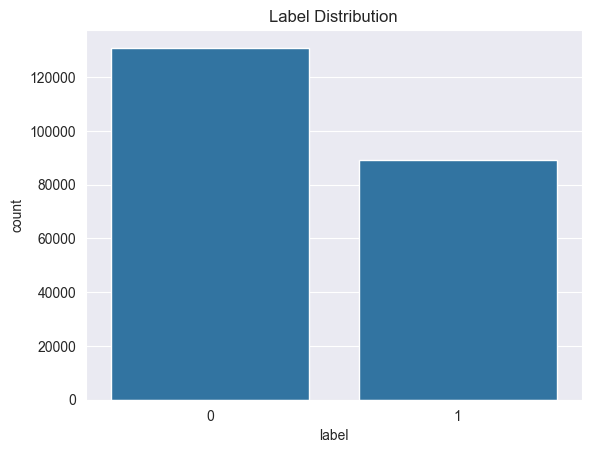

In [19]:
# Look at the distribution of the labels.  An even distribution would be best for training.  However, an imbalance is expected with many 0's and few 1's because most of the population does not have cancer.
sns.countplot(x='label', data=train_labels)
plt.title('Label Distribution')
plt.show()

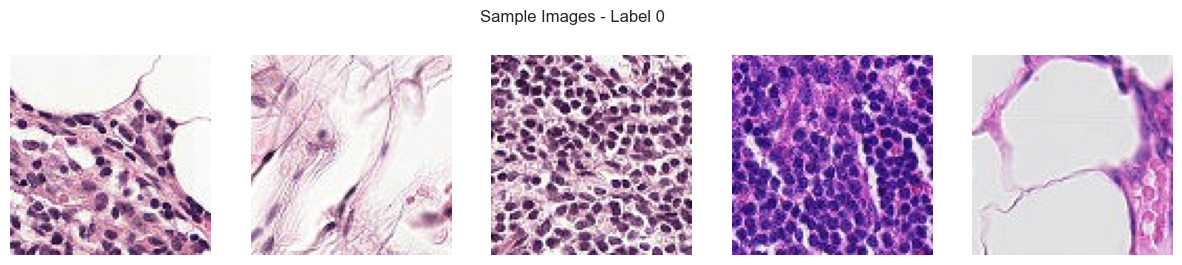

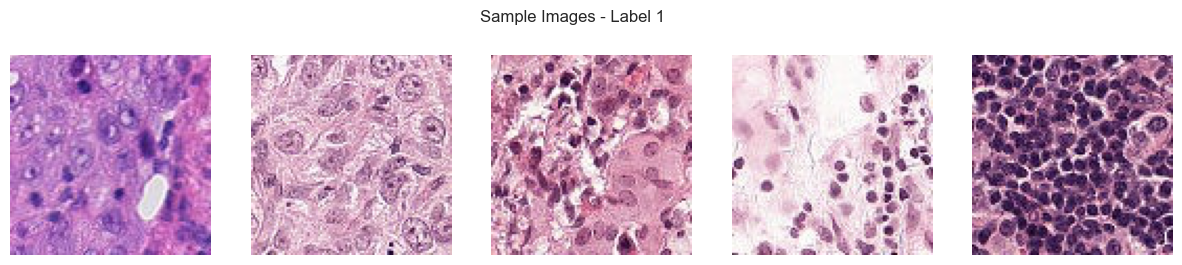

In [20]:
# View a few image examples, including images with a label of 0 and 1, to get an understanding of the images used in the project.
def show_samples(label, num_samples=5):
    samples = train_labels[train_labels['label'] == label].sample(num_samples)
    plt.figure(figsize=(15, 3))
    for i, image_id in enumerate(samples['id']):
        img_path = os.path.join(train_dir, image_id + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Sample Images - Label {label}')
    plt.show()

show_samples(label=0)
show_samples(label=1)

    
# Part 3 - Model Architecture

Various types of convolutional neural networks (CNNs) can be used to solve this issue.  Since the dataset for this project contains many gigabytes of information, it is important to choose a model that can be trained efficiently so that I am able to test it on my personal PC.  Ideally the model would take less than a minute to train so that I can perform hyperparameter tuning with various options without spending excessive time.

In [21]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_baseline_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

baseline_model = create_baseline_model()
baseline_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               3965056   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [22]:
def create_advanced_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

advanced_model = create_advanced_model()
advanced_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 128)      

# Part 4 - Results and Analysis 

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In [15]:
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.engine import data_adapter

def _is_distributed_dataset(ds):
    return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)

data_adapter._is_distributed_dataset = _is_distributed_dataset

train_labels, val_labels = train_test_split(train_labels, test_size=0.2, stratify=train_labels['label'], random_state=42)

# Convert labels to strings
train_labels['label'] = train_labels['label'].astype(str)
val_labels['label'] = val_labels['label'].astype(str)

# Create a new 'filename' column by adding '.tif' extension
train_labels['filename'] = train_labels['id'] + '.tif'
val_labels['filename'] = val_labels['id'] + '.tif'

# Data Generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='filename',  # Use the new 'filename' column
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_labels,
    directory=train_dir,
    x_col='filename',  # Use the new 'filename' column
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
advanced_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_baseline = baseline_model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

# history_advanced = advanced_model.fit(
#     train_generator,
#     epochs=5,
#     validation_data=val_generator
# )

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/5
    126/Unknown - 8s 59ms/step - loss: 0.6475 - accuracy: 0.6347

KeyboardInterrupt: 

In [12]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

plot_history(history_baseline, 'Baseline Model')
plot_history(history_advanced, 'Advanced Model')

NameError: name 'history_baseline' is not defined

# Step 5 - Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?